In [44]:
%matplotlib inline

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math

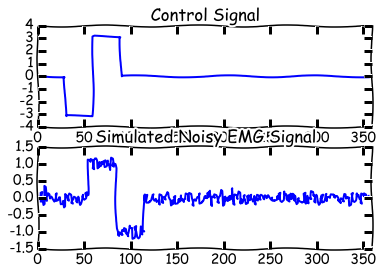

In [46]:
plt.xkcd()  # Yes...

tmax = 360

t = tmax*np.linspace(0, 1, tmax, endpoint=False)

contSig = np.zeros(tmax)

steps = tmax/4
for i in range(0, tmax, step):
    contSig[i:i+(steps/3)] = 0
    contSig[i+(steps/3):i+(2*steps/3)] = -math.pi
    contSig[i+(2*steps/3):i+steps] = math.pi

# Two subplots, unpack the axes array immediately
plt.figure(figsize=(40,40))
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)

ax1.plot(t, contSig)
ax1.set_ylim([-4, 4])
ax1.set_xlim(0,tmax)
ax1.set_title('Control Signal')

delay = 25

noise = np.random.normal(0,0.1,tmax)
simEMG = [0] * (tmax+delay)

for i in range(1,tmax):
    if contSig[i] == 0:
        simEMG[i + delay] = 0
    elif contSig[i] == -math.pi:
        simEMG[i + delay] = 1
    elif contSig[i] == math.pi:
        simEMG[i + delay] = -1
        
simEMGdiff = simEMG[0:tmax]+noise

ax2.plot(t, simEMGdiff)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlim(0,tmax)
ax2.set_title('Simulated Noisy EMG Signal')

In [47]:
# Implement a learning algorithm to try to fit the signal

# store the variables for plitting after learning
jointAngle = np.zeros(tmax)

# Initialize the state array for the trajectory
# Possible feedback from the simulated arm includes the angle
# (in radians) and angular velocity (in radians per second) of
# each joint, and the Cartesian position of the end effector.

# The continuous state space is composed of joint angles 
# and differential EMG signals
s = np.array([0,0])

# Initialize the learning parameters
gamma = 0.99
lambd = 0.3

x = 0

m = 1

alpha = 0.1/m
alphaV = 0.1/m
alphaW = 0.1/m

stdC = 102 # 1023
r = 0

delta = np.zeros(tmax)

agentMean = np.zeros(tmax)
agentStd = np.zeros(tmax)

# Initialize the weight vectors
# the should be as long as the feature vector x
wU = np.zeros(m)
wS = np.zeros(m)
v = np.zeros(m)
elU = np.zeros(m)
elS = np.zeros(m)
elV = np.zeros(m)

def featurize(s):
    
    x = 0
    
    # use a representation to get a featurized state space
    # break it down into a smaller dimensionality
    
    # simple representation is two states 
    # if the joint angle is less than or equal to zero that is a single state
    # if the joint angle is greater than 0 that is a different state
    if s[0] > 0:
        x = 1
            
    return x

def getReward(newAngle,timeStep):
    # Define the reward function of the system
    # A positive reward of rt = 1.0 was
    # delivered when θw and θe were both within 0.1 radians of
    # their target angles. A reward of rt = −0.5 was delivered
    # in all other cases, in essence penalizing the learning system
    # when the arm’s posture differed from the target posture.
    targetAngle = contSig[timeStep]
    
    absAngleError = np.abs(newAngle-targetAngle)
    
    if absAngleError < 0.1:
        r = 0.1
    else:
        r = -0.5

    return r

def perform(a,s,timeStep):
    
    # take the action and observe the new state and the reward 
    # new state is defined by the new joint angle
    # which is defined by the old joint angle and the new angular velocity
    # which is applied for that time step and the
    # emg signal at that time index 
    
    # Calculate the new angular state of the joint
    # old angle + angular velocity * time (in this case time = 5ms, the period of action selection)
    # this limits the amount of motion of the joint possible in each action selection
    
    newAngle = s[0] + a * 0.0005
    
    if newAngle < -math.pi:
        newAngle = -math.pi
    elif newAngle > math.pi:
        newAngle = math.pi
    
    s = np.array([newAngle,simEMGdiff[timeStep]])
    
    r = getReward(newAngle,timeStep)
    
    return r,s

# process the training samples that are given
for i in range(tmax):
        
    x = featurize(s)
    
    # store joint angles for plotting
    jointAngle[i] = s[0]
    
    agentMean[i] = np.dot(wU,x)
    
    # standard deviation is bounded to be equal to or greater than 1
    agentStd[i] = max(1,np.exp(np.dot(wS,x) + np.log(stdC)))
    
    # get the action from the normal distribution
    a = round(np.random.normal(agentMean[i],agentStd[i]))
    
    # angular velocity commands are sent to joints (simulated servos) 
    # as integers in the range [−1023, 1023] in radians/sec
    
    if a < -1023:
        a = -1023
    elif a > 1023:
        a = 1023
 
    # take action a and observe the reward, r, and the new state, s
    r,s = perform(a,s,i)
                     
    newX = featurize(s)
    
    delta[i] = r + (gamma * np.dot(v,newX)) - np.dot(v,x)
    elV = lambd * elV + x
    v = v + alphaV * delta[i] * elV
    elU = lambd * elU + (alpha - agentMean[i]) * x
    wU = wU + alphaW * delta[i] * elU
    elS = lambd * elS + (np.power((alpha - agentMean[i]),2) / np.power(agentStd[i],2) - 1) * x
    wS = wS + alphaW * delta[i] * elS
    
#     print 'Step: ' + str(i)
#     print 'Joint Angle: ' + str(jointAngle[i]) + ' radians'
#     print 'Target Angle: ' + str(contSig[i]) + ' radians'
#     print 'Agent Mean: ' + str(agentMean[i])
#     print 'Agent Std: ' + str(agentStd[i])
#     print 'Action: ' + str(a) + ' radians per second'
#     print 'New Joint Angle: ' + str(s[0]) + ' radians'
#     print 'Reward: ' + str(r)
#     print 'TD Error: ' + str(delta[i])
#     print '\n'

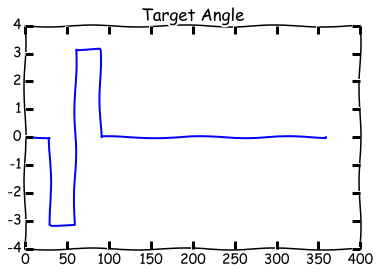

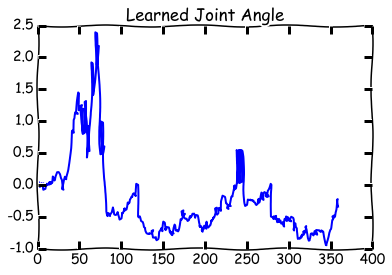

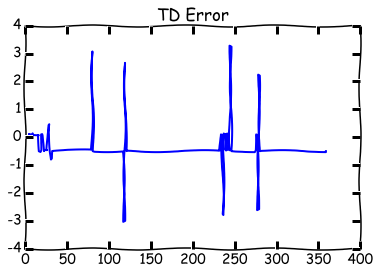

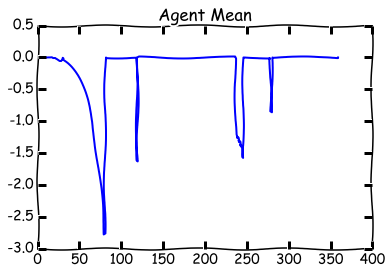

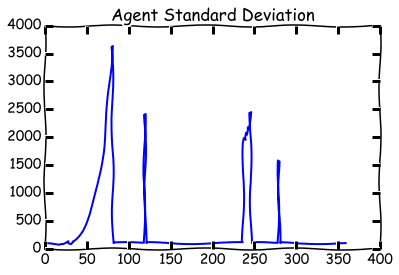

In [48]:
# Visualize the learning    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, contSig)
ax1.set_ylim(-4,4)
ax1.set_title('Target Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, jointAngle)
ax1.set_title('Learned Joint Angle')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, delta)
ax1.set_title('TD Error')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentMean)
ax1.set_title('Agent Mean')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t, agentStd)
ax1.set_title('Agent Standard Deviation')